# Dataset

In [3]:
import torch
# Load MNIST dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 28
BATCH_SIZE = 128

train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

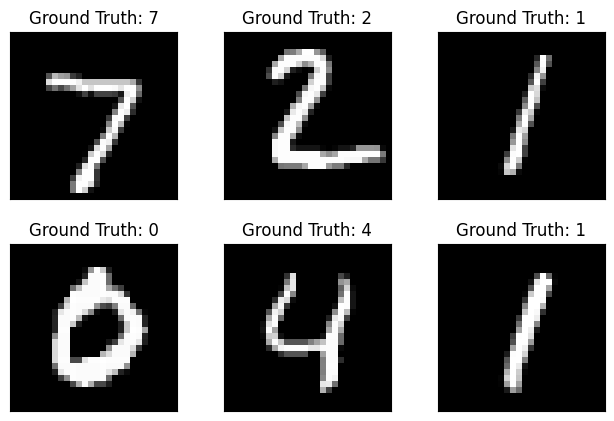

In [4]:
# sample a photo
import matplotlib.pyplot as plt
import numpy as np
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data = example_data.numpy()
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Noise Schedular

In [ ]:
def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)  # returns a 1D tensor of betas, linearly spaced between beta_start and beta_end

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t)  
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)  

# Precalculated values
T = 200
betas = linear_beta_schedule(timesteps=T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0) # this is alphas_cumprod at t-1, padded with 1.0 at t=0 cuz there is no t-1 for t=0
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)




def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0).to(device)  
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise 

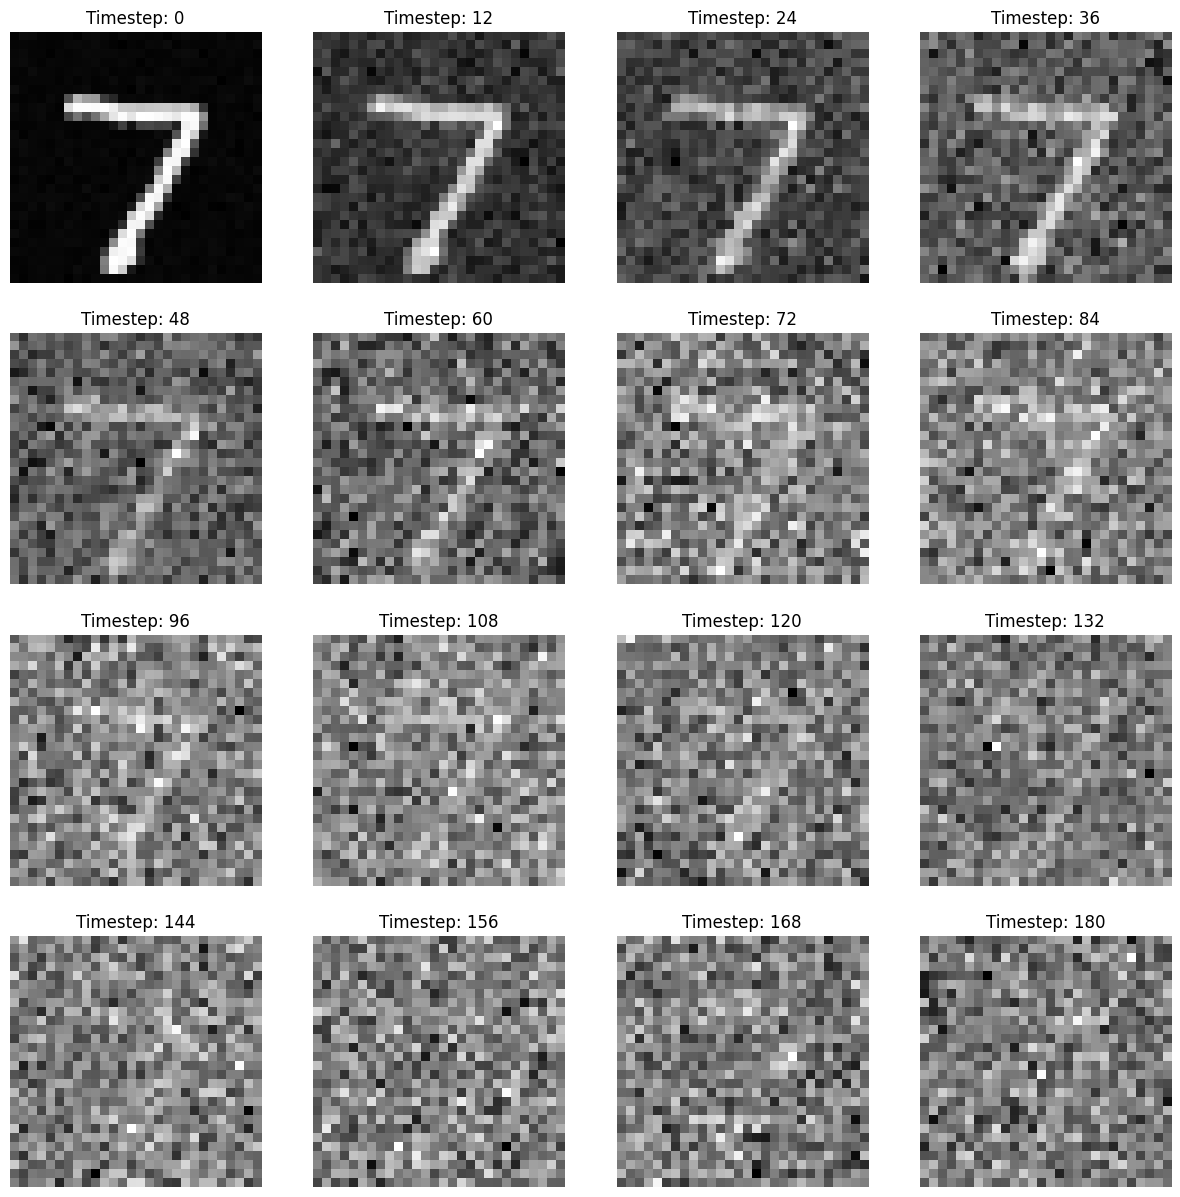

In [18]:
# Simulate forward diffusion
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

T = 200
img = next(iter(test_loader))[0][0].unsqueeze(0)  # Grab a sample image from the test dataset
fig = plt.figure(figsize=(15, 15))
for i in range(0, T-T//16, T // 16):
    t = torch.Tensor([i]).long()
    noisy_img, _ = forward_diffusion_sample(img, t, device="cpu")
    noisy_img = noisy_img.numpy().reshape(28, 28)  # Ensure the image is 2D
    ax = fig.add_subplot(4, 4, i // (T // 16) + 1)
    ax.imshow(noisy_img, cmap='gray')  # Pass the 2D image
    ax.set_title(f'Timestep: {i}')
    ax.axis('off')
plt.show()